# 08. PyTorch Paper Replicating

The goal of machine learning research paper replicating is: turn a ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch.

## 0. Get Setup

Let's import code we've previously written + required libraries.

In [1]:
# Continue with regular imports 
import matplotlib.pyplot as plt 
import torch
import torchvision

from torch import nn
from torchvision import transforms

from torchinfo import summary
from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [2]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 1. Get Data

The whole goal of what we're trying to do is to replicate the VIT architecture for our FoodVision Mini problem.

To do that, we need some data.

Namely, the pizza steak sushi images we've been using so far.

In [3]:
# Download pizza, steak, sushi images from Github
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [4]:
image_path

WindowsPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and Dataloaders

### 2.1 Prepare transforms for images

In [6]:
# Create image size
IMAGE_SIZE = 224 # comes from Table 3 vit paper


# Create transforms pipeline
manual_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

print(f'Manually created transforms: {manual_transform}')



Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### 2.2 Create DataLoaders

In [7]:
# Create batch size
BATCH_SIZE = 32 # Paper uses 4026 but my device can't handle it.

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transform,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

As always, let's adhere to the motto, visualize, visualize, visualize!

In [8]:
images, labels = next(iter(train_dataloader))
images[0], labels[0]

(tensor([[[0.3098, 0.3020, 0.2824,  ..., 0.0431, 0.0471, 0.0549],
          [0.3137, 0.3176, 0.2784,  ..., 0.0471, 0.0588, 0.0588],
          [0.3137, 0.3059, 0.2784,  ..., 0.0510, 0.0784, 0.0980],
          ...,
          [0.0275, 0.0196, 0.0275,  ..., 0.0275, 0.0314, 0.0196],
          [0.0235, 0.0196, 0.0118,  ..., 0.0196, 0.0157, 0.0196],
          [0.0196, 0.0235, 0.0157,  ..., 0.0235, 0.0235, 0.0275]],
 
         [[0.0941, 0.1020, 0.1059,  ..., 0.0118, 0.0078, 0.0157],
          [0.1098, 0.1216, 0.1059,  ..., 0.0118, 0.0196, 0.0118],
          [0.1176, 0.1216, 0.1137,  ..., 0.0118, 0.0275, 0.0353],
          ...,
          [0.0314, 0.0235, 0.0314,  ..., 0.0196, 0.0235, 0.0118],
          [0.0275, 0.0235, 0.0157,  ..., 0.0118, 0.0078, 0.0118],
          [0.0235, 0.0275, 0.0196,  ..., 0.0157, 0.0157, 0.0196]],
 
         [[0.0588, 0.0471, 0.0353,  ..., 0.0157, 0.0118, 0.0157],
          [0.0627, 0.0667, 0.0353,  ..., 0.0157, 0.0157, 0.0118],
          [0.0627, 0.0588, 0.0392,  ...,

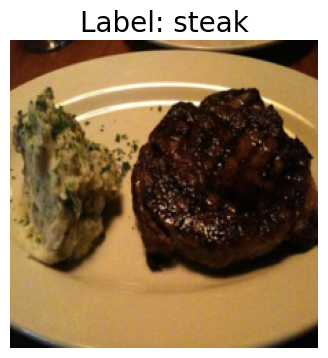

In [9]:
# Plot the image with matplotlib 
plt.figure(figsize=(4,4))
plt.imshow(images[0].permute(1, 2, 0)) # Matplotlib wants color channel last
plt.title(f'Label: {class_names[labels[0]]}', size=20)
plt.axis('off')
plt.show()

## 3. Replicating ViT: Overview

Looking at a whole machine learning research paper can be intimidating.

So in order to make it more understandable, we break it down in smaller pieces.

* **Inputs** - What goes into the model? (in our case, image tensors)
* **Outputs** - What comes out the model/layer/block? (in our case, we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self attention).
* **Blocks** - Collection of layers.
* **Model** - Collection of Blocks

### 3.1 ViT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for the architecture/training.
* Text descriptions (especially section 3.1)



### Figure 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from vision transformer paper"/>

* Embedding = learnable representation (start with random numbers and improve over time) 



### Four equations

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=600 alt="four equations from vision transformer paper"/>

#### Section 3.1 describes the various equations:

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2,......image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ..... ,image_patch_N_pos]
```



---

**Equations 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:

```python
# Equation 2 
x_output_MSA_block = MSA_Layer(LN_layer(x_input)) + x_input

# Equation 3 
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block 
```
---


**Equation 4:**
Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_{L}^{0}$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time 

In pseudocode:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block)) 
```

### Table 1 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt="table 1 from vision transformer paper"/>

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture
* ViT-B/16 = ViT-Base with image patch size 16x16 
* Layers - the number of transformer encoder layers 
* Hidden size $D$ - the embedding size throughout the architecture (for each patch)
* MLP size - the number of hidden units/neurons in the MLP
* Heads - the number of multi-head self-attention 


## 4. Equation 1: Split data into patches and creating class, position and patch Embedding.

Layers = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) -> single image -> (height, width, color channels)
* Output shape: ???

### 4.1 Calculate input and output shapes by hand

> **Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

> **Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input shape: $H\times{W}\times{C}$ (height x width x color channels)
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / p^2
* D = constant latent vector size = embedding dimension (see Table 1)


In [10]:
# Create example values 
height = 224 
width = 224 
color_channels = 3
patch_size = 16

# Calculate the number of patches
num_of_patches = int((height * width) / (patch_size**2))
num_of_patches


196

In [11]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (num_of_patches, patch_size**2 * color_channels)
print(f'Input shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding dimensions')

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding dimensions


### 4.2 Turning a single image into patches

Let's Visualize , Visualize, Visualize

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

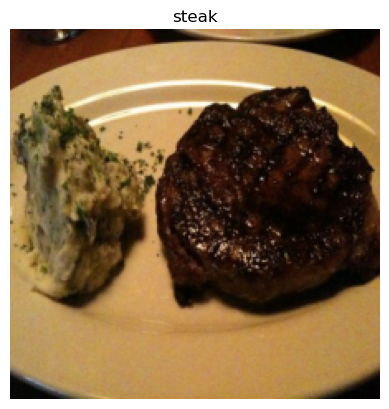

In [12]:
# View a single image
plt.imshow(images[0].permute(1, 2, 0))
plt.title(class_names[labels[0]])
plt.axis('off')

In [13]:
images[0].shape

torch.Size([3, 224, 224])

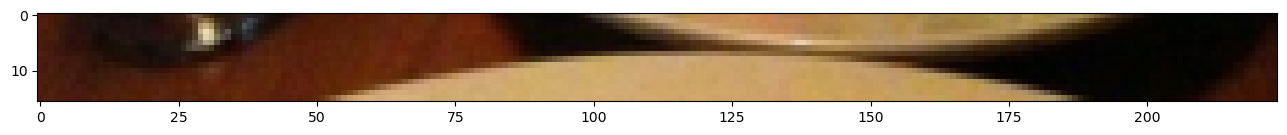

In [14]:
# Get the top row of the image
image_permuted = images[0].permute(1, 2, 0) # convert image to color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])



Number of patches per row: 14.0
Number of patches per Col: 14.0
Patch size: 16 pixels x 16 pixels


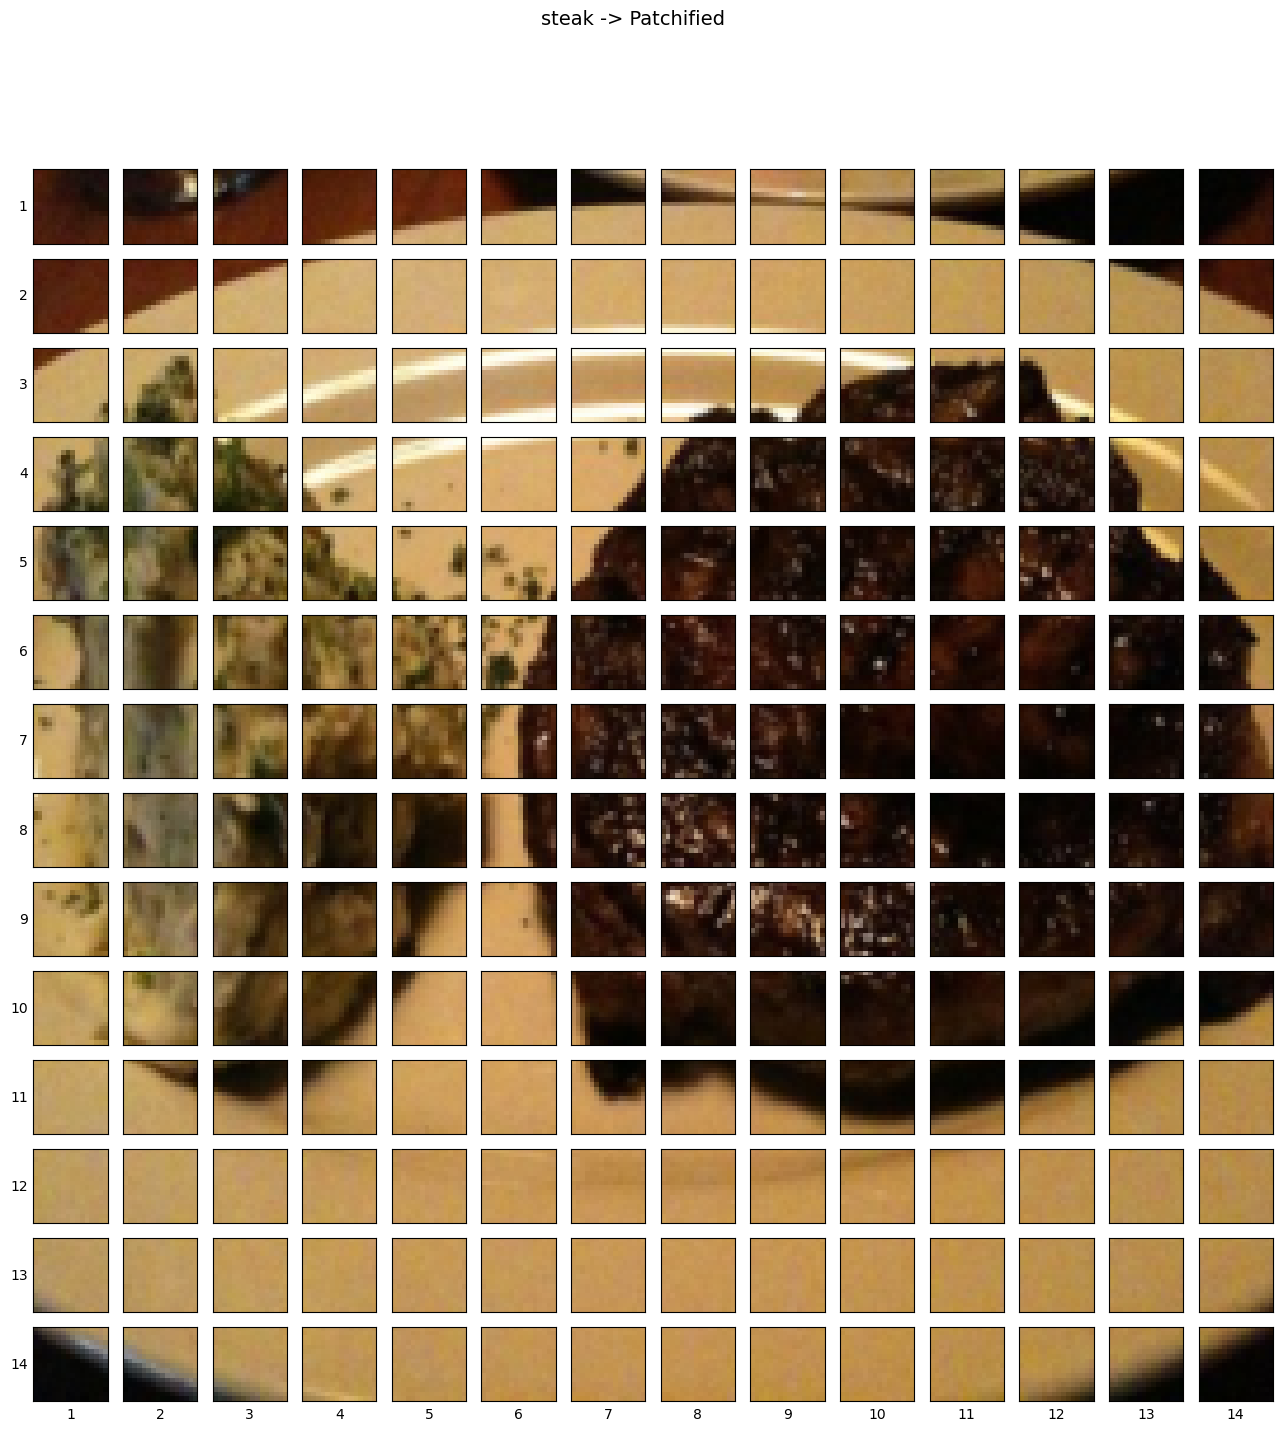

In [15]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, 'Image size must be division by patch size'
print(f'Number of patches per row: {num_patches}\nNumber of patches per Col: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels')

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                       ncols=img_size // patch_size, # one column for each patch
                       sharex=True,
                       sharey=True,
                       figsize=(patch_size, patch_size))

# Itereate through number of pathces in the top row
for i, row_patch in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, col_patch in enumerate(range(0, img_size, patch_size)):
        axs[i,j].imshow(image_permuted[row_patch:row_patch+patch_size, col_patch:col_patch+patch_size, :])
        axs[i,j].set_xlabel(j+1) # Set the patch label
        axs[i,j].set_ylabel(i+1,
                           rotation='horizontal',
                           horizontalalignment='right',
                           verticalalignment='center')
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].label_outer()

# Set up a title for the plot
fig.suptitle(f'{class_names[labels[0]]} -> Patchified', fontsize=14)
plt.show()

In [16]:
14*14

196

### 4.3 Creating image patches and turning them into patch embeddings

perhaps we could create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size` 

In [17]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn 

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the Vit Paper
conv2d = nn.Conv2d(in_channels=3,
                  out_channels=768, # D size from Table 1 for ViT-Base
                  kernel_size=patch_size,
                  stride=patch_size,
                  padding=0)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

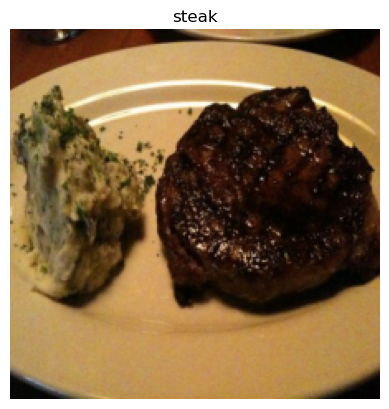

In [18]:
# Views singe image
plt.imshow(images[0].permute(1, 2, 0))
plt.title(class_names[labels[0]])
plt.axis('off')

In [19]:
# Pass the image through convolutional layer
image_out_of_conv = conv2d(images[0].unsqueeze(0)) # add batch dimenstion -> (batch_size, C, H, W)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we've passed a single image to our `conv2d` layer, it's shape is:

```python
torch.size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Showing random convolutional feature maps from indexes: [415, 752, 621, 420, 115]


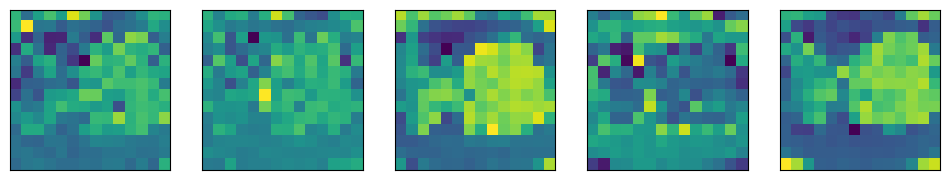

In [20]:
# Plot random convolutional features maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f'Showing random convolutional feature maps from indexes: {random_indexes}')
# Create plot 
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, and remove from grad/backtracking switch to numpy for matplotlib
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    

In [21]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0738,  0.0326,  0.1014,  0.0568, -0.1435, -0.1410, -0.0858,
            0.1265,  0.1633,  0.1349, -0.0311, -0.0036,  0.0343, -0.0234],
          [ 0.0568, -0.1816,  0.0608,  0.1152,  0.1946,  0.1869,  0.1838,
            0.1642,  0.2059,  0.1830,  0.2104,  0.1697,  0.1098,  0.0255],
          [ 0.1012,  0.3654,  0.0872,  0.2998,  0.1670,  0.0777,  0.0673,
            0.1602,  0.3762,  0.3325,  0.1083,  0.1316,  0.1111,  0.1730],
          [ 0.1970,  0.1568,  0.1370,  0.2960,  0.1729,  0.2691,  0.3085,
            0.2043,  0.0881,  0.0721,  0.0308,  0.0650,  0.1530,  0.2216],
          [ 0.0666,  0.1314,  0.0320,  0.0100,  0.2664,  0.2582,  0.3978,
            0.0469,  0.0395, -0.0007,  0.0172,  0.1456,  0.0060,  0.1359],
          [ 0.2450,  0.0872,  0.2054,  0.0802,  0.1354,  0.2406,  0.0570,
            0.0324,  0.1006,  0.0507,  0.0765,  0.0691,  0.0335, -0.0718],
          [ 0.2767,  0.0912,  0.1243,  0.2484,  0.2281,  0.2201,  0.0207,
           -0.1195,  0.0407,  0.

### 4.4 Flatenning the patch embedding with `torch.nn.Flatten()`

Right now we've got a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence of patch embedding to satisfy the criteria of the ViT transformer Encoder.

In [22]:
print(f'{image_out_of_conv.shape} -> [batch_size, embedding_dim, feature_map_height, feature_map_width]')


torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]


Want: (batch_size, number_of_patches, embedding_dim)

In [23]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


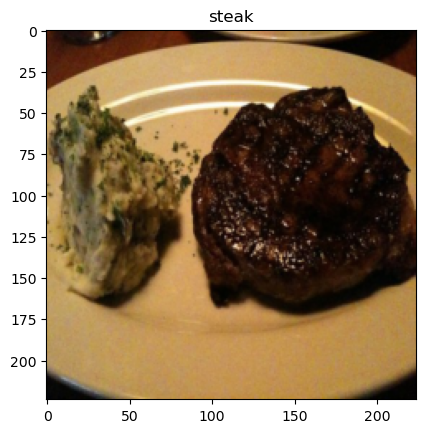

In [24]:
# Put everything together
plt.imshow(images[0].permute(1, 2, 0))
plt.title(class_names[labels[0]])
print(f'Original image shape: {images[0].shape}')

# Turn image into feature maps
image_out_of_conv = conv2d(images[0].unsqueeze(0)) # add batch dimension
print(f'Image feature map (patches) shape: {image_out_of_conv.shape}')

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f'Flattened image feature map shape: {image_out_of_conv_flattened.shape}')

In [25]:
# Rearrange output of flattened layer
print(f'{image_out_of_conv_flattened.permute(0, 2, 1).shape} -> [batch_size, number of patches, embedding dimension]')

torch.Size([1, 196, 768]) -> [batch_size, number of patches, embedding dimension]


(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

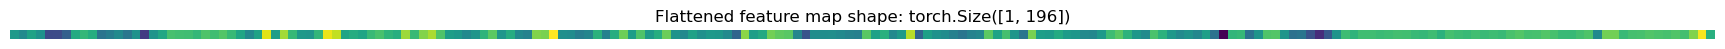

In [26]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened.permute(0, 2, 1)[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape: {single_flattened_feature_map.shape}')
plt.axis(False)

### 4.5 Turning the ViT patch embedding layer into a PyTorch module

We want this module to do few things:

1. Create a class called `PatchEmbedding` that inherits from `nn.Module`
2. Initialize with appropriate hyperparameters, such as channels, embedding dims, patch size.
3. Create a layer to turn an image into embedded patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines the forwarad computation (e.g pass through layer from 3 and 4)
6. Make sure the output shape of the layer reflexts the required output shape of the patch embedding.


In [27]:
import torch
from torch import nn

class PatchEmbedding(nn.Module):
    """
    A neural network module that converts an input image into a sequence of embedded patches,
    as used in Vision Transformer (ViT) architectures.

    Attributes:
    -----------
    patcher : nn.Conv2d
        A convolutional layer that splits the image into patches and projects them into a higher-dimensional embedding space.

    flatten_layer : nn.Flatten
        A layer that flattens the spatial dimensions (patch grid) into a sequence.

    Parameters:
    -----------
    input_shape : int
        Number of input channels in the image (e.g., 3 for RGB images). Default is 3.

    embedding_dim : int
        Dimension of the embedding space for each patch. Default is 768.

    patch_size : int
        Size of each square patch (patch_size x patch_size). Default is 16.
    """

    def __init__(self, input_shape: int = 3,
                       embedding_dim: int = 768,
                       patch_size: int = 16):
        super().__init__()
        self.patch_size = patch_size  # store for use in forward()

        # 1. Convolutional layer to extract non-overlapping patches and embed them
        self.patcher = nn.Conv2d(
            in_channels=input_shape,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )

        # 2. Flatten layer to convert feature maps into a sequence of patch embeddings
        self.flatten_layer = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass to convert input image into a sequence of patch embeddings.

        Parameters:
        -----------
        x : torch.Tensor
            Input tensor of shape (batch_size, channels, height, width)

        Returns:
        --------
        torch.Tensor
            Output tensor of shape (batch_size, num_patches, embedding_dim)
        """

        # Validate image size
        image_height, image_width = x.shape[-2], x.shape[-1]
        assert image_height % self.patch_size == 0 and image_width % self.patch_size == 0, \
            (f"Input image dimensions must be divisible by patch_size={self.patch_size}, "
             f"but got image size ({image_height}, {image_width})")

        # 1. Apply patch embedding (Conv2d)
        x = self.patcher(x)

        # 2. Flatten spatial dimensions (patch grid) into a sequence
        x = self.flatten_layer(x)

        # 3. Rearrange to (batch_size, num_patches, embedding_dim)
        return x.permute(0, 2, 1)


In [28]:
from going_modular.utils import set_seeds
set_seeds

# Create an instance of patch embedding layer
patchify = PatchEmbedding()

# Pass the single image through patch embedding layer
print(f'Input image size: {images[0].unsqueeze(0).shape}')
patch_embedded_image = patchify(images[0].unsqueeze(0))
print(f'Output patch embedding sequence shape: {patch_embedded_image.shape}')

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [29]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

#patchify(rand_image_tensor_bad)

### 4.6 Creating the class token embedding

Want to: prepend a learnable class token to the start of patch embedding

In [30]:
patch_embedded_image

tensor([[[ 0.0425, -0.2076,  0.0295,  ..., -0.0563,  0.0326,  0.0850],
         [-0.0910, -0.2172,  0.0025,  ..., -0.0276,  0.1207,  0.1185],
         [ 0.0859, -0.1873, -0.0372,  ..., -0.0604,  0.0534,  0.0833],
         ...,
         [-0.1947, -0.4673, -0.1729,  ..., -0.1241,  0.0243,  0.2053],
         [-0.2454, -0.3547, -0.0881,  ..., -0.0531, -0.0861,  0.0478],
         [-0.0294, -0.1762,  0.0314,  ..., -0.0120, -0.0951,  0.0853]]],
       grad_fn=<PermuteBackward0>)

In [31]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension


(1, 768)

In [32]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                          requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [33]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [34]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                     dim=1) # number_of_patches dimension
print(patch_embedded_image_with_class_embedding)
print(f'Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -[B, num_of_patches, embedding_dim]')

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.0425, -0.2076,  0.0295,  ..., -0.0563,  0.0326,  0.0850],
         [-0.0910, -0.2172,  0.0025,  ..., -0.0276,  0.1207,  0.1185],
         ...,
         [-0.1947, -0.4673, -0.1729,  ..., -0.1241,  0.0243,  0.2053],
         [-0.2454, -0.3547, -0.0881,  ..., -0.0531, -0.0861,  0.0478],
         [-0.0294, -0.1762,  0.0314,  ..., -0.0120, -0.0951,  0.0853]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -[B, num_of_patches, embedding_dim]


### 4.7 Creating the position embedding

Want to: Create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings. 

In [35]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.0425, -0.2076,  0.0295,  ..., -0.0563,  0.0326,  0.0850],
          [-0.0910, -0.2172,  0.0025,  ..., -0.0276,  0.1207,  0.1185],
          ...,
          [-0.1947, -0.4673, -0.1729,  ..., -0.1241,  0.0243,  0.2053],
          [-0.2454, -0.3547, -0.0881,  ..., -0.0531, -0.0861,  0.0478],
          [-0.0294, -0.1762,  0.0314,  ..., -0.0120, -0.0951,  0.0853]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [36]:
# Calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1, 
                                            number_of_patches+1,
                                            embedding_dimension))

position_embedding, position_embedding.shape


(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [37]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

### 4.8 Putting it all together: from image to embedding

We've written code to turn an image into a flattened sequence of patch embedding.

In [38]:
# Set seeds()
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# 1. Set the patch size
patch_size = 16

# 2. Print shapes of the original image tensor and get the image dimensions
x = images[0].unsqueeze(0) # add batch dimension
print(f'Input Image Shape: {x.shape}')
height, width = x.shape[2], x.shape[3]

# 3. Create patch embedding layer
patcher = PatchEmbedding(input_shape=3,
                        embedding_dim=768,
                        patch_size=16)

# 4. Pass input image through patcher
patch_embedding = patcher(x)
print(f'Patch Embedding Shape: {patch_embedding.shape}')

# 5. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_embedding = nn.Parameter(torch.zeros(batch_size, 1, embedding_dimension),
                              requires_grad=True) # make sure it's learnable
print(f'Class Embedding shape: {class_embedding.shape}')

# 6. Let's prepend class embedding to patch embedding
patch_emd_with_class_emd = torch.cat([class_embedding, patch_embedding],
         dim=1)
print(f'Patch Embedding with Class Embedding shape: {patch_emd_with_class_emd.shape}')

# 7. Let's create a position embedding
number_of_patches = int((height*width) / patch_size**2)
pos_embedding = nn.Parameter(torch.zeros(1, number_of_patches+1, embedding_dimension),
                            requires_grad=True)
print(f"Position Embedding shape: {pos_embedding.shape}")

# add pos_embedding to patch_emd_with_class_emd
pos_emd_with_class_and_patch_emd = patch_emd_with_class_emd + pos_embedding
print(f'Position Embedding added with Class and Patch Embedding shape: {pos_emd_with_class_and_patch_emd.shape}')

Input Image Shape: torch.Size([1, 3, 224, 224])
Patch Embedding Shape: torch.Size([1, 196, 768])
Class Embedding shape: torch.Size([1, 1, 768])
Patch Embedding with Class Embedding shape: torch.Size([1, 197, 768])
Position Embedding shape: torch.Size([1, 197, 768])
Position Embedding added with Class and Patch Embedding shape: torch.Size([1, 197, 768])


In [39]:
# Let's create a whole class (ImageEmbedder)
class ImageEmbedder(nn.Module):
    '''
    Complete embedding layer for Vision Transformer
    Patch Embedding + Class Token + Positional Embedding
    '''
    def __init__(self, input_shape: int=3,
                embedding_dim: int=768,
                patch_size: int=16,
                image_size: int = 224,
                embedding_dropout:float=0.1):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim

        self.patch_embedding = PatchEmbedding(
            input_shape=input_shape,
            embedding_dim=embedding_dim,
            patch_size=patch_size
        )

        # Compute number of patches
        self.num_patches = (image_size // patch_size) ** 2

        # Learnable class token
        self.class_token = nn.Parameter(
            torch.zeros(1, 1, embedding_dim)
        )

        # Learnable position embedding
        self.pos_embedding = nn.Parameter(
            torch.zeros(1, self.num_patches + 1, embedding_dim)
        )

        # Adding Dropout
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]

        # patch embedding
        x = self.patch_embedding(x) # [B, N, E]

        # Expand class token for batch
        class_token = self.class_token.expand(batch_size, -1, -1) # [B, 1, E]

        # Prepend class token to patch embeddings
        x = torch.cat([class_token, x], dim=1) # [B, N+1, E]

        # Add positional embeddings
        x = x + self.pos_embedding # [B, N+1, E]

        # Pass to dropout layer
        x = self.embedding_dropout(x)

        return x 

In [40]:
# Set seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Input image
x = images[0].unsqueeze(0)  # [1, 3, H, W]
print(f"Input Shape: {x.shape}")

# Create embedding model
embedder = ImageEmbedder(input_shape=3,
                         embedding_dim=768,
                         patch_size=16,
                         image_size=224)  

# Get final embedding
embedding_output = embedder(x)
print(f"Final Embedding Shape: {embedding_output.shape}")


Input Shape: torch.Size([1, 3, 224, 224])
Final Embedding Shape: torch.Size([1, 197, 768])


## Equation 2: Multihead Sefl-Attention ( MSA BLOCK)

* Multihead self-attention: Which part of a sequence should pay the most attention to itself?
* In our case, we have of series of embedded image patches, which patch significantly related to another patch.
* We want our neural network (ViT) to learn this relationship/representation.
* LayerNorm
* Normalization = make everything have the same mean and same std.
normalizes values over $D$ dimension, in our case embedding dimension.
* When we normalize along the embeddinig dimension, it's like making all of the stairs in the stair case the same size.

In [41]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block (MSA Block for short.)"""

    def __init__(self, 
                embedding_dim:int=768, # Hidden size D (embedding dimension) from Table 1 for VitBase
                num_heads:int=12, # heads from Table 1
                 attn_dropout:int=0,
                ):
        super().__init__()
        # Create the norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create multi-head attention layer (MSA)
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True # is the batch first ? (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                            key=x,
                                            value=x,
                                            need_weights=False)
        return attn_output
        

In [42]:
multihead_self_attention_block = MultiHeadSelfAttentionBlock()

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(embedding_output)
print(f'Input shape of MSA Block: {embedding_output.shape}')
print(f'Output shapea of MSA block: {patched_image_through_msa_block.shape}')

Input shape of MSA Block: torch.Size([1, 197, 768])
Output shapea of MSA block: torch.Size([1, 197, 768])


In [43]:
embedding_output

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-0.1690, -0.0000, -0.0398,  ...,  0.0000, -0.1002,  0.1454],
         [-0.1671,  0.1181,  0.1309,  ...,  0.0558, -0.0000,  0.1050],
         ...,
         [-0.5289,  0.1251, -0.0974,  ...,  0.3446, -0.2946,  0.2230],
         [-0.4010,  0.1036,  0.0209,  ...,  0.0957, -0.2567,  0.0000],
         [ 0.0443, -0.0850, -0.0237,  ...,  0.1009, -0.1729,  0.0194]]],
       grad_fn=<MulBackward0>)

In [44]:
patched_image_through_msa_block

tensor([[[ 0.2061, -0.4676,  0.4615,  ...,  0.6590,  0.1802,  0.3025],
         [ 0.2254, -0.4898,  0.4557,  ...,  0.6375,  0.1903,  0.3153],
         [ 0.2205, -0.4891,  0.4422,  ...,  0.6412,  0.1912,  0.3198],
         ...,
         [ 0.2181, -0.4865,  0.4508,  ...,  0.6515,  0.1918,  0.3064],
         [ 0.2210, -0.4853,  0.4486,  ...,  0.6499,  0.1951,  0.3156],
         [ 0.2121, -0.4716,  0.4585,  ...,  0.6568,  0.1847,  0.3200]]],
       grad_fn=<TransposeBackward0>)

## 6. Multilayer Perceptron BLock (MLP)

* **MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1)
* MLP = a quiet braod term for a block with a series of layer(s), layers can be multiple or even only one hidden layer.
* Layers can mean: fully connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch, they're often called `torch.nn.Linear()`
* MLP number of hidden units = MLP size in Table 1.\\
* **Dropout** : value for dropout in Table 3. (p=0.1)
In pseudocode:
```python
# MLP
x = linear -> non-linear - dropout -> linear -> droput

In [45]:
class MLPBlock(nn.Module):
    def __init__(self,
                embedding_dim:int=768,
                mlp_size:int=3072, # From Table 1.
                dropout:int=0.1):
        super().__init__()

        # Create the norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the MLP 
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        mlp_output = self.mlp(x)
        return mlp_output

In [46]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                    mlp_size=3072,
                    dropout=0.1)

# Pass output of the msa block to mlp block
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f'Input shape of MLP block: {patched_image_through_msa_block.shape}')
print(f'Output shape of MLP block: {patched_image_through_mlp_block.shape}')

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


In [47]:
patched_image_through_msa_block

tensor([[[ 0.2061, -0.4676,  0.4615,  ...,  0.6590,  0.1802,  0.3025],
         [ 0.2254, -0.4898,  0.4557,  ...,  0.6375,  0.1903,  0.3153],
         [ 0.2205, -0.4891,  0.4422,  ...,  0.6412,  0.1912,  0.3198],
         ...,
         [ 0.2181, -0.4865,  0.4508,  ...,  0.6515,  0.1918,  0.3064],
         [ 0.2210, -0.4853,  0.4486,  ...,  0.6499,  0.1951,  0.3156],
         [ 0.2121, -0.4716,  0.4585,  ...,  0.6568,  0.1847,  0.3200]]],
       grad_fn=<TransposeBackward0>)

In [48]:
patched_image_through_mlp_block

tensor([[[-0.1858, -0.2083,  0.1513,  ...,  0.2174,  0.0314, -0.1740],
         [-0.1536, -0.0556,  0.2015,  ...,  0.4160, -0.0203, -0.1791],
         [-0.1598, -0.1096,  0.1677,  ...,  0.2889,  0.0342, -0.2315],
         ...,
         [-0.1895, -0.1635, -0.0365,  ...,  0.0842,  0.0908, -0.1980],
         [-0.1961, -0.1973,  0.2224,  ...,  0.4136,  0.0917, -0.1714],
         [-0.0573, -0.1061,  0.1853,  ...,  0.3677,  0.0415, -0.1837]]],
       grad_fn=<MulBackward0>)

## 7. Creating the Transformer Encoder

The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP(equation 3).

And there are residual connections between each block.

* Encoder = turn a sequence into learnable representation
* Decoder = go from learned representation back to some sort of sequence.
* Residual connections = add a layer(s) input to its subsequent output , this enables to creation of deeper networks (prevents weights from getting too small)

In pseudocode:
```
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input]-> ...

### 7.1 Create a custom Transformer Encoder Block

In [49]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                embedding_dim:int=768, # hidden size D from Table 1,
                num_heads:int=12,
                mlp_size:int=3072,
                mlp_dropout:int=0.1,
                attn_dropout:int=0):
        super().__init__()

        # Create MSA block (equation 2)
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    attn_dropout=attn_dropout)

        # Create MLP Block (equation 3)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                mlp_size=mlp_size,
                                 dropout=mlp_dropout)


    def forward(self, x):
        x = self.msa_block(x) + x  # residual/skip connection for equation 2
        x = self.mlp_block(x) + x # residual/skip connection for equation 3
        return x 
        
    
    

In [50]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
       input_size=(1, 197, 768) ,# (batch_size, number_of_patches, embedding_dimension)
       col_names=['input_size', 'output_size', 'num_params', 'trainable'],
       col_width=20,
       row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### 7.2 Create a Transformer Encoder Layer with inbuild PyTorch layers

So far we've created a transformer encoder by hand.

But because of how good the transformer architecture is, PyTorch has implemented ready to use Transformer Encoder layers

We can create a Transformer Encoder with pure PyTorch layers.

In [51]:
# Create the same as above with torch.nn.TransformerEncoderLayer
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768, # embedding size from table 1
    nhead=12, # heads from table 1
    dim_feedforward=3072, # MLP size from table 1
    dropout=0.1,
    activation='gelu',
    batch_first=True,
    norm_first=True,
)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [52]:
# Get a summary using torchinfo.summary
summary(model=torch_transformer_encoder_layer,
       input_size=(1, 197, 768) ,# (batch_size, number_of_patches, embedding_dimension)
       col_names=['input_size', 'output_size', 'num_params', 'trainable'],
       col_width=20,
       row_settings=['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

Why spend all this time recreating transformer encoder when we could've just made it with single pytorch layer?

Practice. Practice. Practice.

Now we know how things implemented behind the scenes , we can tweak them if necessary

What are the benefits of using a pre-build PyTorch layer?

* Less prone to errors (goes through a bunch of testing)
* Potential benefit of speed ups (performance boost)

## 8. Putting it all together to create ViT

In [53]:
# Create a ViT class 
class ViT(nn.Module):
    def __init__(self,
                img_size:int=224, # Table 3 from ViT paper
                in_channels:int=3,
                patch_size:int=16,
    num_transformer_layers:int=12, # Table 1 for "Layers" for ViT base
    embedding_dim:int=768, # hidden size D from Table 1 for ViT base
    mlp_size:int=3072,
    num_heads:int=12,
    attn_dropout:int=0,
    mlp_dropout:int=0.1,
    embedding_dropout:int=0.1, # Dropout for patch and position embedding
    num_classes:int=1000): # Number of classes in our classification problem
        
    

        super().__init__()
    
        # Use ImageEmbedder Class to convert the image into Projection Vector D 
        self.embedding_layer = ImageEmbedder(input_shape=3,
                                embedding_dim=embedding_dim,
                                patch_size=patch_size,
                                    image_size=224,
                                    embedding_dropout=embedding_dropout)
    
    
        # Create the Transformer Encoder block
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                         num_heads=num_heads,
                                                         mlp_size=mlp_size,
                                                         mlp_dropout=mlp_dropout,
                                                         attn_dropout=attn_dropout
                                                     ) for _ in range(num_transformer_layers)])
    
        
        # Create classfier head 
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                     out_features=num_classes)
        )

    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.transformer_encoder(x)[:, 0, :] # fetching the class embedding only.
        x = self.classifier(x)
        
        return x 
    

In [54]:
x = images[0].unsqueeze(0)  # [1, 3, H, W]
print(f"Input Shape: {x.shape}")

vision_transformer = ViT(num_classes=3)
vision_transformer(images)

Input Shape: torch.Size([1, 3, 224, 224])


tensor([[ 0.7349, -0.0610,  0.9783],
        [ 0.7601, -0.1526,  0.5456],
        [ 0.6847,  0.0191,  0.5156],
        [ 0.5488,  0.0393,  0.7158],
        [ 1.2018, -0.0924,  0.7272],
        [ 0.8377, -0.1535,  0.3853],
        [ 0.6886, -0.3330,  0.7863],
        [ 0.8496,  0.0986,  0.6875],
        [ 0.6860, -0.0458,  0.8180],
        [ 0.7870, -0.2875,  0.5930],
        [ 0.7585,  0.2697,  0.8131],
        [ 0.9899, -0.4834,  0.7859],
        [ 0.5297, -0.1588,  0.4741],
        [ 0.8426, -0.2793,  0.5970],
        [ 0.7967, -0.1571,  0.7986],
        [ 0.9835, -0.5176,  0.4231],
        [ 1.1977, -0.5054,  0.6399],
        [ 0.9474, -0.7371,  0.3170],
        [ 0.7054, -0.3622,  0.5968],
        [ 0.5456, -0.2772,  0.6857],
        [ 0.6988, -0.1143,  0.6911],
        [ 0.7268, -0.0172,  0.6667],
        [ 0.7470, -0.3903,  0.3498],
        [ 0.7525,  0.0758,  0.6798],
        [ 0.7410, -0.2787,  0.6833],
        [ 0.7637, -0.5018,  0.8502],
        [ 0.8771,  0.1268,  0.7962],
 

### 8.1 Getting a visual summary of our model.

In [55]:
summary(model=vision_transformer,
       input_size=(1, 3 ,224, 224) ,# (batch_size, C, H, W)
       col_names=['input_size', 'output_size', 'num_params', 'trainable'],
       col_width=20,
       row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               --                   True
├─ImageEmbedder (embedding_layer)                            [1, 3, 224, 224]     [1, 197, 768]        152,064              True
│    └─PatchEmbedding (patch_embedding)                      [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    │    └─Conv2d (patcher)                                 [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    │    └─Flatten (flatten_layer)                          [1, 768, 14, 14]     [1, 768, 196]        --                   --
│    └─Dropout (embedding_dropout)                           [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768] 

In [56]:
vision_transformer.classifier

Sequential(
  (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (1): Linear(in_features=768, out_features=3, bias=True)
)

## 9. Setting up training code for our custom vit

We've replicated the ViT architecture, now let's see how it performs on our foodvision mini data



In [57]:
optimizer = torch.optim.Adam(params=vision_transformer.parameters(), 
                            lr=1e-3,
                            betas=(0.9, 0.999),
                            weight_decay=0.1)

In [58]:
loss_fn = nn.CrossEntropyLoss()

### 9.1 Training our ViT model

In [59]:
from going_modular import engine

set_seeds()

optimizer = torch.optim.Adam(params=vision_transformer.parameters(), 
                            lr=1e-3,
                            betas=(0.9, 0.999),
                            weight_decay=0.001)

loss_fn = nn.CrossEntropyLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#results = engine.train(model=vision_transformer,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=3,
                      device=device)

IndentationError: unexpected indent (899445405.py, line 14)

### 9.4 What our training setup is missing? 

How is our training setup different to the ViT Paper?

We've replicated model architecture correctly.

But what was different b/w our training procedure to get such poor results and the ViT paper to get such great results?

The main things our training implementation is missing:
* Data - our setup uses far less data (255 vs millions)
* Learing rate warmup - start with a low learning rate and increase to a base LR 
* Learning rate decay - as your model get's closer to convergence, start to lower the LR 
* Gradient clipping - prevent gradients from getting too big



### 9.4 Plotting loss curves from our model

In [103]:
from helper_functions import plot_loss_curves


In [104]:
#plot_loss_curves(results)

## 10. Using a pretrained ViT From `torchvision.models`

Generally, in deep learning if you can use a pretrained model from a large dataset on your own problem, it's often a good place to start.
If you can find a pretrained model and use transfer learning, give it a go, it often achieves great results with little data.

### 10.1 Why use a pretrained model?

* Sometimes data is limited
* Limited training resources
* Get better results faster (sometimes..)

In [135]:
# Get Pretrained weights
weights = torchvision.models.ViT_B_16_Weights.DEFAULT


In [136]:
model = torchvision.models.vit_b_16(weights=weights).to('cpu')
summary(model=model,
       input_size=(1, 3 ,224, 224) ,# (batch_size, C, H, W)
       col_names=['input_size', 'output_size', 'num_params', 'trainable'],
       col_width=20,
       row_settings=['var_names'],
       device='cpu')

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              True
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197, 768

In [137]:
model.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [138]:
# Freeze the base layers
for param in model.parameters():
    param.requires_grad = False

for param in model.heads.parameters():
    param.requires_grad = True


In [139]:
# change the head 
model.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=3, bias=True)
)
model.heads

Sequential(
  (0): Linear(in_features=768, out_features=3, bias=True)
)

In [140]:
summary(model=model,
       input_size=(1, 3 ,224, 224) ,# (batch_size, C, H, W)
       col_names=['input_size', 'output_size', 'num_params', 'trainable'],
       col_width=20,
       row_settings=['var_names'],
       device='cpu')

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 10.2 Prepare a pretrained ViT for use with FoodVision Mini (Turn it to a feature extractor)

When using a pretrained model, you want to make sure your data is formatted  in the same way that the model was trained on.

In [141]:
from going_modular.data_setup import create_dataloaders
import os

# Get automatic transforms from pretrained ViT weigths
preprocess = weights.transforms()

# Setup dataloaders
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                   test_dir=test_dir,
                                                                   transform=preprocess,
                                                                    batch_size=BATCH_SIZE,
                                                                   num_workers=0)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1deb27dc730>,
 ['pizza', 'steak', 'sushi'])

### 10.4 Train feature extractor ViT model

In [145]:
from going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
model.to(device)
pretrained_vit_results = engine.train(model=model,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7323 | train_acc: 0.7656 | test_loss: 0.5094 | test_acc: 0.8068
Epoch: 2 | train_loss: 0.3265 | train_acc: 0.9492 | test_loss: 0.3009 | test_acc: 0.9186
Epoch: 3 | train_loss: 0.2117 | train_acc: 0.9688 | test_loss: 0.2343 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.1531 | train_acc: 0.9648 | test_loss: 0.2237 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.1240 | train_acc: 0.9727 | test_loss: 0.2318 | test_acc: 0.9081
Epoch: 6 | train_loss: 0.1139 | train_acc: 0.9727 | test_loss: 0.2365 | test_acc: 0.9081
Epoch: 7 | train_loss: 0.0939 | train_acc: 0.9805 | test_loss: 0.2372 | test_acc: 0.9081
Epoch: 8 | train_loss: 0.0811 | train_acc: 0.9805 | test_loss: 0.2263 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.0710 | train_acc: 0.9844 | test_loss: 0.2192 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.0649 | train_acc: 0.9883 | test_loss: 0.2138 | test_acc: 0.8977


### 10.5 Plot the loss curves of our pretrained ViT feature extractor model

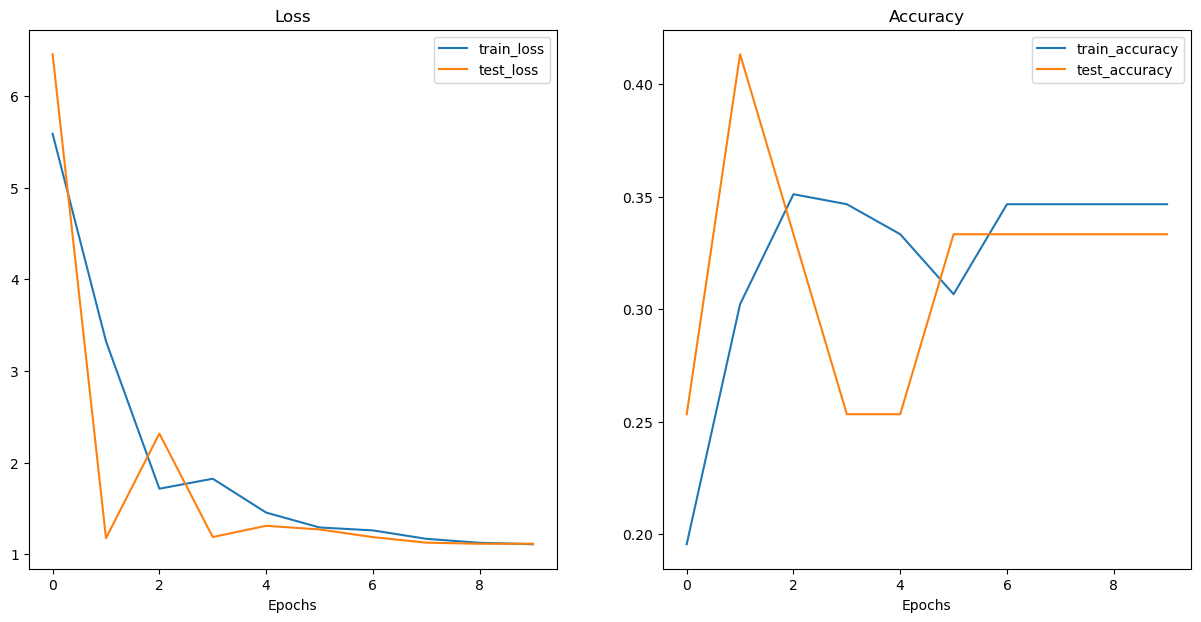

In [146]:
plot_loss_curves(results)

### 10.6 Save our best performing ViT model

Now we've got a model that performs quite well, how about we save it to file and check it's file size.

We want to check the file size because if we wanted to deploy a model to say a website/mobile apps, we may limitations on the size of the model we can deploy.

E.g. a smaller model may be required to compute restrictions.

In [147]:
from going_modular.utils import save_model

In [150]:
save_model(model=model,
          target_dir='models',
          model_name='08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth')

[INFO] Saving model to: models\08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [152]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes

pretrained_vit_model_size = Path('models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth').stat().st_size // (1024 * 1024)
print(f'Pretrained ViT feature Extractor model size: {pretrained_vit_model_size} MB')

Pretrained ViT feature Extractor model size: 327 MB


## 11. Predicting on a custom image

In [153]:
from PIL import Image

In [169]:
import numpy as np
img = Image.open('data/04-pizza-dad.jpeg')

img_tensor = torch.tensor(np.asarray(img)).permute(2, 0, 1)

In [173]:
img_transformed = preprocess(img_tensor)

In [179]:
model.eval()
with torch.inference_mode():
    # forward pass
    y_logits = model(img_transformed.unsqueeze(0).to(device))
y_probs = torch.softmax(y_logits, dim=1 )
y_pred = torch.argmax(y_logits, dim=1)
y_pred.item()

0

In [180]:
class_names[y_pred]

'pizza'

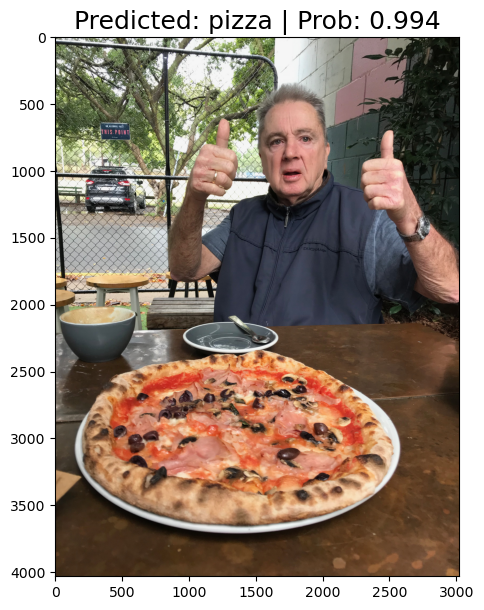

In [198]:
# Let's plot the image
plt.figure(figsize=(10, 7))
plt.imshow(np.asarray(img))
plt.title(f'Predicted: {class_names[y_pred]} | Prob: {torch.max(y_probs, dim=1)[0].item():.3f}', size=18)
plt.show()

In [195]:
torch.max(y_logits, dim=1)[0].item()

3.8862948417663574